In [83]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns

In [84]:
# Load data
train_df = pd.read_csv('../data/playground-series-s5e3/train.csv')
test_df = pd.read_csv('../data/playground-series-s5e3/test.csv')

# Prepare features and target
X = train_df.drop(['id', 'rainfall'], axis=1)
y = train_df['rainfall']
X_test_full = test_df.drop(['id'], axis=1)

# Enhanced data preprocessing pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create preprocessing pipeline
preprocessor = make_pipeline(
    SimpleImputer(strategy='median', add_indicator=True),
    StandardScaler()
)

# Apply preprocessing
X = preprocessor.fit_transform(X)
X_test_full = preprocessor.transform(X_test_full)

# Convert to numpy arrays and ensure proper data types
X = np.asarray(X, dtype=np.float32)
X_test_full = np.asarray(X_test_full, dtype=np.float32)

# Detailed data validation with logging
def validate_data(data, name):
    print(f'\nValidating {name}...')
    print(f'Shape: {data.shape}')
    print(f'Memory usage: {data.nbytes / 1024 / 1024:.2f} MB')
    
    # Check for NaN values
    nan_count = np.isnan(data).sum()
    if nan_count > 0:
        nan_indices = np.where(np.isnan(data))
        print(f'NaN values found in columns: {np.unique(nan_indices[1])}')
        print(f'NaN counts per column: {np.isnan(data).sum(axis=0)}')
        raise ValueError(
            f'Found {nan_count} NaN values in {name} at indices: {nan_indices}'
        )
    
    # Check for infinite values
    inf_count = np.isinf(data).sum()
    if inf_count > 0:
        inf_indices = np.where(np.isinf(data))
        print(f'Infinite values found in columns: {np.unique(inf_indices[1])}')
        raise ValueError(
            f'Found {inf_count} infinite values in {name} at indices: {inf_indices}'
        )
    
    # Check value ranges
    print(f'Min values: {np.min(data, axis=0)}')
    print(f'Max values: {np.max(data, axis=0)}')
    print(f'Mean values: {np.mean(data, axis=0)}')
    print(f'Std values: {np.std(data, axis=0)}')
    print(f'Validation of {name} completed successfully\n')

validate_data(X, 'training features')
validate_data(X_test_full, 'test features')
validate_data(y.values.reshape(-1, 1), 'training labels')


Validating training features...
Shape: (2190, 11)
Memory usage: 0.09 MB
Min values: [-1.7013608 -2.5825882 -2.824286  -3.1703448 -3.592372  -3.9254372
 -5.5183015 -4.0905757 -1.0328039 -1.1860244 -1.7586906]
Max values: [1.7593873 3.7137563 1.7042515 1.445437  1.5084938 1.1812369 2.0468948
 1.3471073 2.304668  2.439694  3.8089914]
Mean values: [ 7.6751183e-09 -4.3827445e-08 -3.4782985e-08 -3.1571410e-09
 -2.7788284e-08 -5.5113882e-09  1.4560952e-08 -3.8756628e-08
 -1.0614526e-09 -5.1235499e-08  4.7139380e-08]
Std values: [0.9999997  1.0000007  0.9999986  1.0000005  0.99999976 1.0000002
 0.99999934 0.9999985  0.9999979  0.9999996  0.999999  ]
Validation of training features completed successfully


Validating test features...
Shape: (730, 11)
Memory usage: 0.03 MB
Min values: [-1.7013608 -2.4057248 -3.3549738 -3.457634  -3.5528302 -3.8686965
 -5.5183015 -4.201549  -1.0328039 -1.1860244 -1.7485859]
Max values: [1.7593873 3.2892835 1.6688724 1.5028948 1.3700982 1.1812369 2.0468948
 1.347

In [85]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [86]:
# Forward stepwise feature selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.pipeline import Pipeline

# Initialize models
log_reg = LogisticRegression(random_state=42, max_iter=1000)
xgb = XGBClassifier(
    random_state=42,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='auc'
)
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42
)

# Create feature selection pipeline
selector = SequentialFeatureSelector(
    xgb,
    n_features_to_select='auto',
    direction='forward',
    scoring='roc_auc',
    cv=5
)

# Fit selector on training data
selector.fit(X_train, y_train)

# Transform datasets
X_train = selector.transform(X_train)
X_test = selector.transform(X_test)
X_test_full = selector.transform(X_test_full)

print(f'Selected {X_train.shape[1]} features out of {selector.n_features_in_}')

/home/lau/miniconda3/envs/khdev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:02:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lau/miniconda3/envs/khdev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:02:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lau/miniconda3/envs/khdev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:02:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lau/miniconda3/envs/khdev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:02:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lau/miniconda3/envs/khdev/lib/python3.10/site-packages/xgboost

Selected 5 features out of 11


/home/lau/miniconda3/envs/khdev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:02:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lau/miniconda3/envs/khdev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:02:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lau/miniconda3/envs/khdev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:02:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lau/miniconda3/envs/khdev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:02:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [87]:
# 10-fold cross validation for models
print('Logistic Regression Cross-validation:')
log_reg_cv = cross_val_score(log_reg, X_train, y_train, cv=10, scoring='accuracy')
print(f'CV scores: {log_reg_cv}')
print(f'Mean CV accuracy: {log_reg_cv.mean():.4f}')

print('\nXGBoost Cross-validation:')
xgb_cv = cross_val_score(xgb, X_train, y_train, cv=10, scoring='accuracy')
print(f'CV scores: {xgb_cv}')
print(f'Mean CV accuracy: {xgb_cv.mean():.4f}')

print('\nRandom Forest Cross-validation:')
rf_cv = cross_val_score(rf, X_train, y_train, cv=10, scoring='accuracy')
print(f'CV scores: {rf_cv}')
print(f'Mean CV accuracy: {rf_cv.mean():.4f}')

/home/lau/miniconda3/envs/khdev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:02:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Logistic Regression Cross-validation:
CV scores: [0.875      0.80681818 0.86857143 0.85142857 0.86285714 0.86857143
 0.86857143 0.91428571 0.88       0.85142857]
Mean CV accuracy: 0.8648

XGBoost Cross-validation:


/home/lau/miniconda3/envs/khdev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:02:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lau/miniconda3/envs/khdev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:02:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lau/miniconda3/envs/khdev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:02:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lau/miniconda3/envs/khdev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:02:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lau/miniconda3/envs/khdev/lib/python3.10/site-packages/xgboost

CV scores: [0.84659091 0.8125     0.85714286 0.86285714 0.86285714 0.85142857
 0.86857143 0.86857143 0.89142857 0.85714286]
Mean CV accuracy: 0.8579

Random Forest Cross-validation:
CV scores: [0.88068182 0.82954545 0.88571429 0.84571429 0.85142857 0.84
 0.86857143 0.91428571 0.89142857 0.85142857]
Mean CV accuracy: 0.8659


In [88]:
# Train models on full training set
log_reg.fit(X_train, y_train)
xgb.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Create ensemble model
ensemble = VotingClassifier(
    estimators=[
        ('log_reg', log_reg),
        ('xgb', xgb),
        ('rf', rf)
    ],
    voting='soft'
)
ensemble.fit(X_train, y_train)

# Make predictions
log_reg_pred = log_reg.predict(X_test)
log_reg_pred_proba = log_reg.predict_proba(X_test)[:, 1]

xgb_pred = xgb.predict(X_test)
xgb_pred_proba = xgb.predict_proba(X_test)[:, 1]

rf_pred = rf.predict(X_test)
rf_pred_proba = rf.predict_proba(X_test)[:, 1]

ensemble_pred = ensemble.predict(X_test)
ensemble_pred_proba = ensemble.predict_proba(X_test)[:, 1]

# Make predictions on full test set
test_pred_log_reg = log_reg.predict(X_test_full)
test_pred_xgb = xgb.predict(X_test_full)
test_pred_rf = rf.predict(X_test_full)
test_pred_ensemble = ensemble.predict(X_test_full)

/home/lau/miniconda3/envs/khdev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:02:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/lau/miniconda3/envs/khdev/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [01:02:57] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [89]:
# Evaluate models
def evaluate_model(name, y_true, y_pred, y_pred_proba):
    print(f'\n{name} Validation Set Metrics:')
    print(f'Accuracy: {accuracy_score(y_true, y_pred):.4f}')
    print(f'Precision: {precision_score(y_true, y_pred):.4f}')
    print(f'Recall: {recall_score(y_true, y_pred):.4f}')
    print(f'F1 Score: {f1_score(y_true, y_pred):.4f}')
    print(f'ROC AUC: {roc_auc_score(y_true, y_pred_proba):.4f}')
    
    # Calculate AUC using integration
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = np.trapz(tpr, fpr)
    print(f'Calculated AUC: {auc:.4f}')
    return fpr, tpr, auc

# Evaluate Logistic Regression
log_reg_fpr, log_reg_tpr, log_reg_auc = evaluate_model(
    'Logistic Regression', y_test, log_reg_pred, log_reg_pred_proba
)

# Evaluate XGBoost
xgb_fpr, xgb_tpr, xgb_auc = evaluate_model(
    'XGBoost', y_test, xgb_pred, xgb_pred_proba
)

# Evaluate Random Forest
rf_fpr, rf_tpr, rf_auc = evaluate_model(
    'Random Forest', y_test, rf_pred, rf_pred_proba
)

# Evaluate Ensemble
ensemble_fpr, ensemble_tpr, ensemble_auc = evaluate_model(
    'Ensemble', y_test, ensemble_pred, ensemble_pred_proba
)


Logistic Regression Validation Set Metrics:
Accuracy: 0.8630
Precision: 0.8835
Recall: 0.9424
F1 Score: 0.9120
ROC AUC: 0.8819
Calculated AUC: 0.8819

XGBoost Validation Set Metrics:
Accuracy: 0.8425
Precision: 0.8480
Recall: 0.9636
F1 Score: 0.9021
ROC AUC: 0.8736
Calculated AUC: 0.8736

Random Forest Validation Set Metrics:
Accuracy: 0.8676
Precision: 0.8886
Recall: 0.9424
F1 Score: 0.9147
ROC AUC: 0.8785
Calculated AUC: 0.8785

Ensemble Validation Set Metrics:
Accuracy: 0.8676
Precision: 0.8820
Recall: 0.9515
F1 Score: 0.9155
ROC AUC: 0.8808
Calculated AUC: 0.8808


/tmp/ipykernel_20162/473283506.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)
/tmp/ipykernel_20162/473283506.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)
/tmp/ipykernel_20162/473283506.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)
/tmp/ipykernel_20162/473283506.py:12: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tpr, fpr)


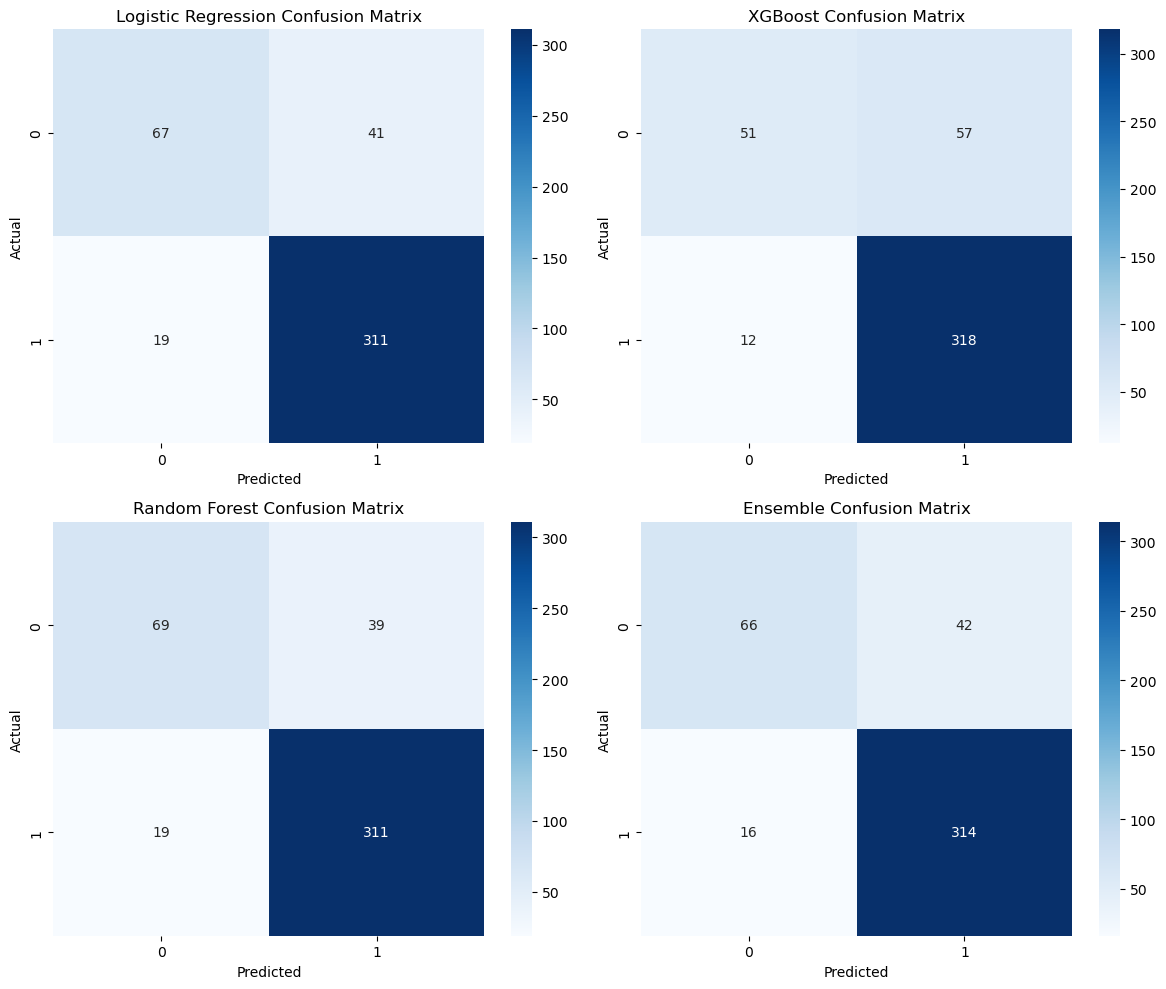

In [90]:
# Confusion matrices
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Logistic Regression confusion matrix
cm_log_reg = confusion_matrix(y_test, log_reg_pred)
sns.heatmap(cm_log_reg, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0])
axes[0, 0].set_title('Logistic Regression Confusion Matrix')
axes[0, 0].set_xlabel('Predicted')
axes[0, 0].set_ylabel('Actual')

# XGBoost confusion matrix
cm_xgb = confusion_matrix(y_test, xgb_pred)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title('XGBoost Confusion Matrix')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# Random Forest confusion matrix
cm_rf = confusion_matrix(y_test, rf_pred)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Random Forest Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# Ensemble confusion matrix
cm_ensemble = confusion_matrix(y_test, ensemble_pred)
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', ax=axes[1, 1])
axes[1, 1].set_title('Ensemble Confusion Matrix')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

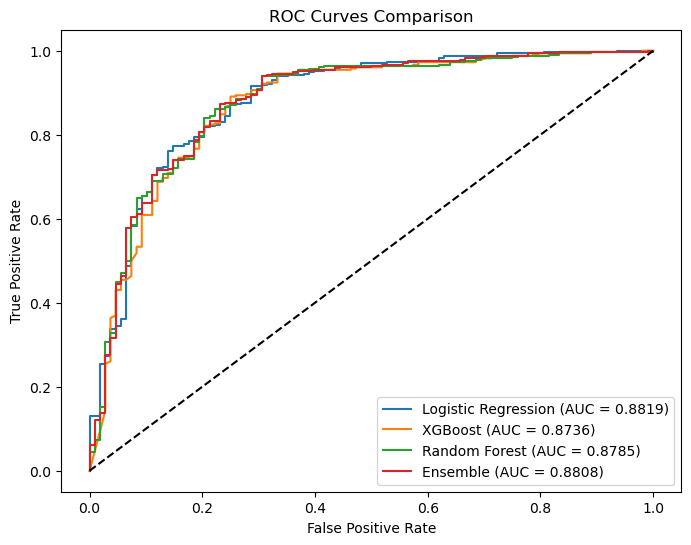

In [91]:
# ROC curves comparison
plt.figure(figsize=(8, 6))
plt.plot(log_reg_fpr, log_reg_tpr, label=f'Logistic Regression (AUC = {log_reg_auc:.4f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.4f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest (AUC = {rf_auc:.4f})')
plt.plot(ensemble_fpr, ensemble_tpr, label=f'Ensemble (AUC = {ensemble_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()